## Content:
- Test a different network architecuture, ResNet
- DataAugmentation: RandomHorizontalFlip, RandomCrop

##### code to build the network ist from:
Source: https://www.kaggle.com/code/toygarr/resnet-implementation-for-image-classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt
from torchvision import transforms
import pickle
from torch.optim import lr_scheduler
from torchsummary import summary

In [13]:
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=train_transform)
test_dataset = CIFAR100(root="./", train=False, download=False, transform=test_transform)

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_dataset))  
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training images train data set: ', len(train_dataset))
print('Number of validation images in train dataset: ', len(val_dataset))
print('Number of test images test data set: ', len(test_dataset))

Number of training images train data set:  40000
Number of validation images in train dataset:  10000
Number of test images test data set:  10000


In [14]:
# Load the label names from metadata file
with open('cifar-100-python/meta', 'rb') as f:
    meta_dict = pickle.load(f, encoding='bytes')
fine_label_names = [t.decode('utf8') for t in meta_dict[b'fine_label_names']]
print(fine_label_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

# Create Model

#### architecture source: https://www.kaggle.com/code/toygarr/resnet-implementation-for-image-classification

![image.png](https://open-instruction.com/loading/2021/05/q.png)

#### Shortcut connections source: https://arxiv.org/pdf/1512.03385.pdf
#### Shortcut connections source: https://towardsdatascience.com/building-a-residual-network-with-pytorch-df2f6937053b
#### Shortcut connections source https://towardsdatascience.com/residual-networks-resnets-cb474c7c834a#:~:text=The%20identity%20block%20is%20the,is%20the%20%E2%80%9Cmain%20path%E2%80%9D.

![image.png](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*dhQQdqZ_XciBou1yAPL8ow.jpeg)

- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.


In [5]:
num_classes = 100

In [6]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)       
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)     
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out

In [8]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = ResNet(3,100)

In [11]:
model = model.to(device)

#### Take a look at the architecture and the number of parameters

In [12]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]           4,160
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8          [-1, 256, 15, 15]         147,712
       BatchNorm2d-9          [-1, 256, 15, 15]             512
           Conv2d-10          [-1, 256, 15, 15]          16,640
      BatchNorm2d-11          [-1, 256, 15, 15]             512
           Conv2d-12           [-1, 64, 15, 15]          16,448
      BatchNorm2d-13           [-1, 64, 15, 15]             128
             ReLU-14           [-1, 64,

### Same training function like always:

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_loss_list = []
    val_loss_list = []
    epoch_list = []

    total_step = len(train_loader)

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        
        model.train()             # activate dropout
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add up the training loss for this batch
            epoch_train_loss += loss.item()

        # Compute the average training loss for this epoch
        epoch_train_loss /= len(train_loader)

        # Append the loss to the train_loss_list
        train_loss_list.append(epoch_train_loss)
        epoch_list.append(epoch+1)
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, epoch_train_loss))

        # Validation
        #model.eval()           # deactivate dropout
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            # Append the average validation loss to the val_loss_list
            val_loss /= len(valid_loader.dataset)
            val_loss_list.append(val_loss)
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
         
        # in each epoch call scheduler 
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print("Current learning rate: {}".format(current_lr))

    # Plot the train and validation loss
    import matplotlib.pyplot as plt
    plt.plot(epoch_list, train_loss_list, label='Train Loss')
    plt.plot(epoch_list, val_loss_list, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [17]:
num_epochs = 100
learning_rate = 0.05

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [18]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=35, gamma = 0.1)

Epoch [1/100], Step [625/625], Loss: 5.1809
Accuracy of the network on the 5000 validation images: 2.52 %
Current learning rate: 0.05
Epoch [2/100], Step [625/625], Loss: 4.2243
Accuracy of the network on the 5000 validation images: 5.79 %
Current learning rate: 0.05
Epoch [3/100], Step [625/625], Loss: 4.0003
Accuracy of the network on the 5000 validation images: 7.83 %
Current learning rate: 0.05
Epoch [4/100], Step [625/625], Loss: 3.8932
Accuracy of the network on the 5000 validation images: 10.57 %
Current learning rate: 0.05
Epoch [5/100], Step [625/625], Loss: 3.7832
Accuracy of the network on the 5000 validation images: 11.42 %
Current learning rate: 0.05
Epoch [6/100], Step [625/625], Loss: 3.7179
Accuracy of the network on the 5000 validation images: 12.87 %
Current learning rate: 0.05
Epoch [7/100], Step [625/625], Loss: 3.6630
Accuracy of the network on the 5000 validation images: 12.58 %
Current learning rate: 0.05
Epoch [8/100], Step [625/625], Loss: 3.6187
Accuracy of th

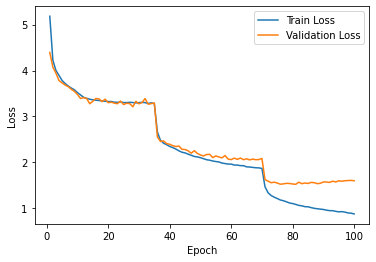

In [19]:
train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs)

#### Evaluation:

In [20]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # auf cpu kopieren um in numpy array umwandeln zu könenn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

target_names = fine_label_names
classification_report_result = classification_report(y_true, y_pred, target_names=target_names)
print(classification_report_result)

Accuracy of the network on the 10000 test images: 58.82 %
               precision    recall  f1-score   support

        apple       0.85      0.72      0.78       100
aquarium_fish       0.57      0.79      0.66       100
         baby       0.47      0.43      0.45       100
         bear       0.49      0.37      0.42       100
       beaver       0.38      0.47      0.42       100
          bed       0.66      0.61      0.63       100
          bee       0.67      0.68      0.67       100
       beetle       0.67      0.58      0.62       100
      bicycle       0.72      0.71      0.72       100
       bottle       0.66      0.68      0.67       100
         bowl       0.52      0.38      0.44       100
          boy       0.48      0.28      0.35       100
       bridge       0.61      0.70      0.65       100
          bus       0.56      0.49      0.52       100
    butterfly       0.50      0.59      0.54       100
        camel       0.56      0.59      0.58       100
      

In [24]:
import pandas as pd
classification_report_result_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_classification_report = pd.DataFrame(classification_report_result_dict).transpose()
df_classification_report[0:len(target_names)]

# Find best classified labels
sorted_df_precision = df_classification_report.sort_values('precision', ascending=False)
top5_sorted_precision = sorted_df_precision[0:5]
header_precision = "ResNet Top 5 labels precision"
sorted_df_precision = top5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
sunflower,0.875000,0.840000,0.857143,100.000000
wardrobe,0.860215,0.800000,0.829016,100.000000
cockroach,0.853333,0.640000,0.731429,100.000000
chair,0.849462,0.790000,0.818653,100.000000
apple,0.847059,0.720000,0.778378,100.000000


In [25]:
sorted_df_precision = df_classification_report.sort_values('precision')
worst5_sorted_precision = sorted_df_precision[0:5]
header_precision = "ResNet worst 5 labels precision"
sorted_df_precision = worst5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
mouse,0.282828,0.280000,0.281407,100.000000
otter,0.283019,0.300000,0.291262,100.000000
woman,0.300000,0.390000,0.339130,100.000000
shrew,0.330097,0.340000,0.334975,100.000000
seal,0.351648,0.320000,0.335079,100.000000


In [26]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score')
worst5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "ResNet worst 5 labels f1-score"
sorted_df_f1_score = worst5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

,precision,recall,f1-score,support
mouse,0.282828,0.280000,0.281407,100.000000
otter,0.283019,0.300000,0.291262,100.000000
shrew,0.330097,0.340000,0.334975,100.000000
seal,0.351648,0.320000,0.335079,100.000000
woman,0.300000,0.390000,0.339130,100.000000


## Summary:



#### - ResNet architecture made a improve 
#### - Less parameter and higher accurancy on test data
#### - Similar classes are classified with a low precision and f1-score: mouse, otter 
#### - ResNet structure made a improve on CIFAR100 compared to VGG architecture